# Automatic Speech Recognition using CTC

## Introduction

이 데모는 2D CNN, RNN 및 연결주의자 시간 분류(CTC) 손실을 결합하여 ASR을 구축하는 방법을 보여줍니다. CTC는 음성 인식, 필기 인식 및 기타 시퀀스 문제에서 심층 신경망을 훈련하는 데 사용되는 알고리즘입니다. CTC는 입력이 출력과 어떻게 정렬되는지 모를 때 사용됩니다(스크립트의 문자가 오디오에 정렬되는 방식). 우리가 만드는 모델은
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)와 유사합니다..

우리는 LJSpeech 데이터셋을 사용할 것입니다.[LibriVox](https://librivox.org/) 7 non-fiction 책을 단일 화자가 읽는 짧은 오디오 클립들로 구성되어 있습니다. 

모델은 WER(단어오류비율)
[Word Error Rate (WER)](https://en.wikipedia.org/wiki/Word_error_rate)을 사용해서 평가됩니다.

WER은 인식하는 동안 식별된 잘못된 단어의 수(substitution, insertion, deletions)를 계산하고, 합계를 휴먼 레이블 대화 기록에 제공된 총 단어 수(다음 공식에서 N으로 표시됨)로 나눈 다음, 해당 몫에 100을 곱하여 오류 비율을 백분율로 계산합니다. 이 계산을 위해 [jiwer](https://pypi.org/project/jiwer/) 를 설치합니다. 


## Setup

In [1]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 13.8 MB/s 
     |████████████████████████████████| 2.2 MB 65.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

## Load the LJSpeech Dataset


[LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/) 데이터 세트를 다운로드해 보겠습니다. 데이터 세트에는 `/wavs/` 폴더에 13,100개의 오디오 파일이 wav 파일로 포함되어 있습니다. 각 오디오 파일의 레이블(transcription)은 `metadata.csv` 파일에 지정된 문자열입니다. 필드는 다음과 같습니다.

- ID: 해당 .wav 파일의 이름입니다.
- transcription: 독자가 말한 단어(UTF-8)
- 정규화된 transcription: 숫자, 서수 및 화폐 단위가 전체 단어로 확장된 transcription(UTF-8).


이 데모에서는 "정규화된 transcription" 필드에서 사용할 것입니다.

각 오디오 파일은 sample rate가 22,050Hz인 단일 채널 16비트 PCM WAV입니다.

In [3]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

2748572632/2748572632 [==============================] - 74s 0us/step


In [4]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df

,file_name,transcription,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [5]:
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True) # 무작위로 순서 섞기
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ029-0101,For the President's return to Love Field follo...
1,LJ029-0177,"Articles, editorials, and letters to the edito..."
2,LJ018-0122,but not before the forged paper had been put i...


이제 데이터를 훈련 세트와 검증 세트로 나눕니다.

In [6]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


## Preprocessing


먼저 사용할 vocabulary를 준비합니다.

- StringLookup 
    - 문자열을 정수 인덱스에 매핑하는 전처리 layer
    - https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup


In [7]:
vocab = ["a", "b", "c", "d"]
data = tf.constant([["a", "c", "d"], ["d", "z", "b"]])

# layer (StringLookup : mapping method like dictionary)
layer = keras.layers.StringLookup(vocabulary=vocab)

# 결과
layer(data)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[1, 3, 4],
       [4, 0, 2]])>

In [8]:
# 대본에 사용할 수 있는 문자 집합입니다.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
print('acceptable characters : ', characters)

# characters -> 정수 
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# 정수 -> characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

acceptable characters :  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


데이터 전처리를 위한 함수를 만듭니다. 

<div>
<img src="https://miro.medium.com/max/1400/1*tIBRdtG3EfjmSIlraWVIxw.png" width="400"/>
</div>

In [9]:
# 오디오 전처리 예시 

wav_file_ex = df_train['file_name'][0]
label_ex = df_train['normalized_transcription'][0]

# An integer scalar Tensor. The window length in samples.
frame_length = 256

# An integer scalar Tensor. The number of samples to step.
frame_step = 160

# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

# 1. Read wav file
file_ex = tf.io.read_file(wavs_path + wav_file_ex + ".wav")
print('after step 1 :', file_ex, end='\n\n')

# 2. Decode the wav file
audio_ex, _ = tf.audio.decode_wav(file_ex) # wav -> float tensor 변환
audio_ex = tf.squeeze(audio_ex, axis=-1)
print('after step 2 :', audio_ex, end='\n\n')

# 3. Change type to float
audio_ex = tf.cast(audio_ex, tf.float32)

# 4. Get the spectrogram (short time Fourier transform, tf 이외에도 사용가능능)
spectrogram_ex = tf.signal.stft(
    audio_ex, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
)
print('after step 4 :', spectrogram_ex, end='\n\n')

# 5. We only need the magnitude, which can be derived by applying tf.abs
spectrogram_ex = tf.abs(spectrogram_ex)
spectrogram_ex = tf.math.pow(spectrogram_ex, 0.5)
print('after step 5 :', spectrogram_ex, end='\n\n')


# 6. normalisation
means_ex = tf.math.reduce_mean(spectrogram_ex, 1, keepdims=True) 
stddevs_ex = tf.math.reduce_std(spectrogram_ex, 1, keepdims=True) 
spectrogram_ex = (spectrogram_ex - means_ex) / (stddevs_ex + 1e-10)
print('step6 means and stddevs:', means_ex.shape, stddevs_ex.shape, end='\n\n')
print('after step 6 :', spectrogram_ex, end='\n\n')


after step 1 : tf.Tensor(b'RIFF^\x15\x06\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00"V\x00\x00D\xac\x00\x00\x02\x00\x10\x00data:\x15\x06\x00\xb7\xffp\xff?\x00\xf6\xff\xe8\xff\xa1\x00g\xff\x11\xff2\x009\xff\xba\xff\x92\x00\x90\xff\xe3\xff\x02\x00\xe9\xfe1\x01\x13\x00a\xff\xe4\x00@\xffG\x00\xa4\x00u\xfe\xe7\xff\xd9\xff\xb0\xff\x87\x00D\xff\xca\xff\x91\xff\xf0\xff*\x01:\x00\x0e\x00O\x00\x18\xffo\x00u\x004\xffL\x00f\xffE\x00\x02\x01\xa3\xffP\x008\x00\xd2\xff\x94\x00R\x00\x80\x00u\xff\xd0\xffC\x00\xae\xff\x8d\x00\xba\xff\xf8\xff\xce\xff\x0b\x00h\x00\xd0\xffq\x00R\x00Y\xff\x80\x00K\xff\x9a\xff\x05\x00\x9f\xff\xe4\xff\x8f\xff\xeb\x00\x1c\x00\xf4\xfe%\x01\\\x00\xeb\xfe\x99\x01\xea\xff\x15\x00\xc8\x00\xc9\xff\xfa\xffx\x00h\x00\x02\x00\x05\x00}\x00\x8b\x00\x12\x00\xd3\x00\x99\xff(\x00\xe0\x00\xc2\xfe8\x00V\x00{\xff6\x00%\x00\xd8\xff\x84\xff\x7f\x00\xb6\xff\x9e\xfe\xd3\x00^\xff\xba\xff\x9b\x00\xfa\xfe\xcf\x00>\x00{\xff\xbb\x00\xef\xff;\x00:\x00_\xff\xc7\x00n\xff\xba\x00\xfe\xff&\xff8\x01\x05\x00T

In [10]:
###########################################
##  Process the label
##########################################
# 7. Convert label to Lower case
label_ex = tf.strings.lower(label_ex)
print('after step 7 :', label_ex, end='\n\n')

# 8. Split the label (결과에서의 b : binary를 뜻함.)
label_ex = tf.strings.unicode_split(label_ex, input_encoding="UTF-8")
print('after step 8 :', label_ex, end='\n\n')

# 9. Map the characters in label to numbers
label_ex = char_to_num(label_ex)
print('after step 9 :', label_ex, end='\n\n')

after step 7 : tf.Tensor(b"for the president's return to love field following the luncheon, the agents selected the most direct route, which was approximately four miles.", shape=(), dtype=string)

after step 8 : tf.Tensor(
[b'f' b'o' b'r' b' ' b't' b'h' b'e' b' ' b'p' b'r' b'e' b's' b'i' b'd'
 b'e' b'n' b't' b"'" b's' b' ' b'r' b'e' b't' b'u' b'r' b'n' b' ' b't'
 b'o' b' ' b'l' b'o' b'v' b'e' b' ' b'f' b'i' b'e' b'l' b'd' b' ' b'f'
 b'o' b'l' b'l' b'o' b'w' b'i' b'n' b'g' b' ' b't' b'h' b'e' b' ' b'l'
 b'u' b'n' b'c' b'h' b'e' b'o' b'n' b',' b' ' b't' b'h' b'e' b' ' b'a'
 b'g' b'e' b'n' b't' b's' b' ' b's' b'e' b'l' b'e' b'c' b't' b'e' b'd'
 b' ' b't' b'h' b'e' b' ' b'm' b'o' b's' b't' b' ' b'd' b'i' b'r' b'e'
 b'c' b't' b' ' b'r' b'o' b'u' b't' b'e' b',' b' ' b'w' b'h' b'i' b'c'
 b'h' b' ' b'w' b'a' b's' b' ' b'a' b'p' b'p' b'r' b'o' b'x' b'i' b'm'
 b'a' b't' b'e' b'l' b'y' b' ' b'f' b'o' b'u' b'r' b' ' b'm' b'i' b'l'
 b'e' b's' b'.'], shape=(143,), dtype=string)

after step 9 : tf.T

In [11]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256

# An integer scalar Tensor. The number of samples to step.
frame_step = 160

# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):

    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file_ = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file_) # wav -> float tensor 변환
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True) # 특정 차원을 제거하고 평균
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True) # 특정 차원을 제거하고 표준편차
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)


    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


## Creating `Dataset` objects

우리는  변환된 요소를 입력에 나타난 순서와 동일한 순서로 생성하는 데이터 집합의 개체 `tf.data.Dataset`를 만듭니다.


In [12]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Visualize the data

오디오 클립, 스펙트럼 프로그램 및 해당 레이블을 포함한 데이터 집합의 예를 시각화합니다.

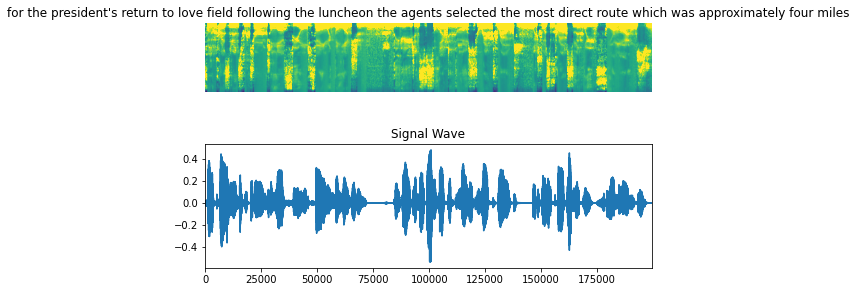

In [13]:
fig = plt.figure(figsize=(8, 5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file_ = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file_)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=22050))

plt.show()

## Model

We first define the CTC Loss function.

- https://keras.io/ko/backend/


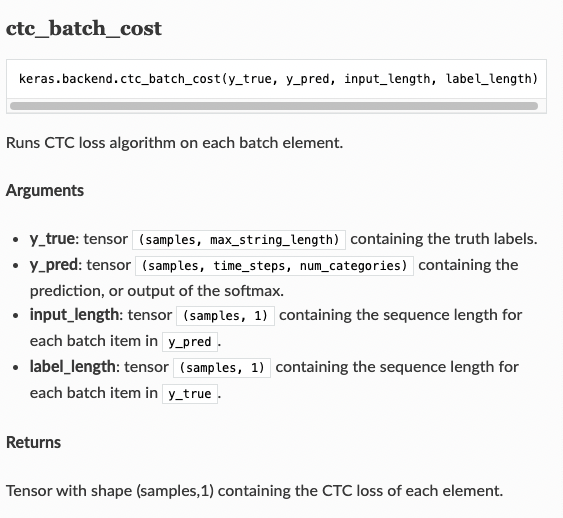

In [14]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

#### DeepSpeech2 model 구조

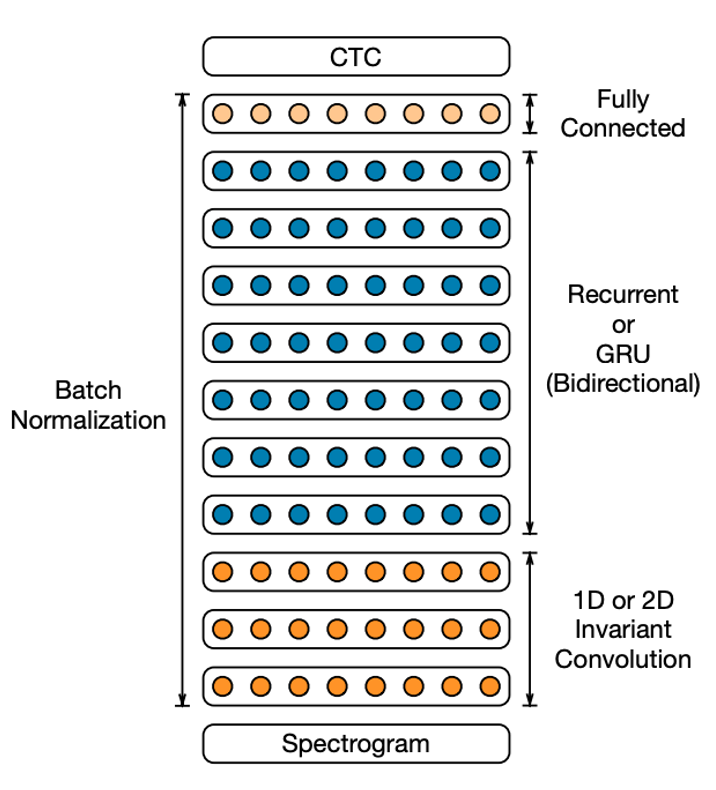

In [23]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")

    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    ###########################################
    ##  Conv Layers 
    ##########################################
    # Convolution layer 1
    x = layers.Conv2D(  filters = 32,
                        kernel_size = [11, 41], 
                        strides = [2, 2],
                        padding = 'same', 
                        use_bias=False,
                        name = 'conv_1', 
                        activation='relu'
    )(x)
    x = layers.BatchNormalization(name = 'conv_1_batchnorm')(x)
    # Convolution layer 2
    x = layers.Conv2D(filters = 32, 
                      kernel_size = [11, 21], 
                      strides = [1, 2],
                      padding = 'same', 
                      use_bias=False,
                      name = 'conv_2', 
                      activation='relu'
    )(x)
    x = layers.BatchNormalization(name = 'conv_2_batchnorm')(x)

    x = layers.Conv2D(filters = 64, 
                      kernel_size = [11, 21], 
                      strides = [1, 2],
                      padding = 'same', 
                      use_bias=False,
                      name = 'conv_3', 
                      activation='relu'
    )(x)
    x = layers.BatchNormalization(name = 'conv_3_batchnorm')(x)

    ###########################################
    ## RNN layers 
    ##########################################

    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent_layer = layers.GRU(
            units = rnn_layers,
            activation = 'tanh',
            recurrent_activation = 'sigmoid',
            use_bias = True,
            return_sequences = True,
            reset_after = True,
            name = f'gru_{i}'
        )
        x = layers.Bidirectional(
            recurrent_layer,
            name = f'bidirectional_{i}',
            merge_mode = 'concat'
        )(x)

        if i < rnn_layers:
            x = layers.Dropout(rate = 0.4)(x)
    ###########################################
    ## Output Layer
    ##########################################

    # Dense layer
    x = layers.Dense(256, activation = 'relu6')(x)
    x = layers.Dense(128, activation = 'relu6')(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)


    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_batchnorm (BatchNormalization)           (None, None, 97, 32)                     

## Training and Evaluating

In [24]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [25]:
for i in range(5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)
    file_ = tf.io.read_file(wavs_path + list(df_val["file_name"])[i] + ".wav")
    audio, _ = tf.audio.decode_wav(file_)
    audio = audio.numpy()
    display.display(display.Audio(np.transpose(audio), rate=22050))

NameError: ignored

Let's start the training process.

In [26]:
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "./speech_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 다섯 번째 에포크마다 가중치를 저장하기 위한 콜백을 만듭니다
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

NameError: ignored

In [27]:
# Define the number of epochs.
epochs = 50 
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, cp_callback],
)


NameError: ignored

In [28]:
# epochs 20까지 학습한 모델 다운로드
!gdown --id 1EjsQ-ETyruGpKR-ddRtqwGF-fd5Zkbd2

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1EjsQ-ETyruGpKR-ddRtqwGF-fd5Zkbd2 



In [29]:
!unzip /content/asr_checkpoint.zip

unzip:  cannot find or open /content/asr_checkpoint.zip, /content/asr_checkpoint.zip.zip or /content/asr_checkpoint.zip.ZIP.


In [ ]:
# 새로운 모델 객체를 만듭니다
new_model =

# 가중치를 복원합니다

new_model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

## Inference

Target    : oswald struck his wife on occasion
Prediction: oswald's truck his wife on occasion
----------------------------------------------------------------------------------------------------


Target    : the convicts were pinioned one by one and sent singly out to the gallows
Prediction: the convicts were pinioned one by one and sinate singly out to the gallows
----------------------------------------------------------------------------------------------------


Target    : this steward was practically supreme
Prediction: this it stewared was practicaly supreme
----------------------------------------------------------------------------------------------------


Target    : she testified that she told him quote
Prediction: she testified that she told him quote
----------------------------------------------------------------------------------------------------


Target    : the law made it imperative that every prison should have a prison chapel and that daily and sunday services should be held
Prediction: the long maded imperative that every prison should have a prison chapel and that daily and sunday services should be held
----------------------------------------------------------------------------------------------------


## Conclusion

In practice, you should train for around 50 epochs or more. Each epoch
takes approximately 5-6mn using a `GeForce RTX 2080 Ti` GPU.
The model we trained at 50 epochs has a `Word Error Rate (WER) ≈ 16% to 17%`.

Some of the transcriptions around epoch 50:

**Audio file: LJ017-0009.wav**
```
- Target    : sir thomas overbury was undoubtedly poisoned by lord rochester in the reign
of james the first
- Prediction: cer thomas overbery was undoubtedly poisoned by lordrochester in the reign
of james the first
```

**Audio file: LJ003-0340.wav**
```
- Target    : the committee does not seem to have yet understood that newgate could be
only and properly replaced
- Prediction: the committee does not seem to have yet understood that newgate could be
only and proberly replace
```

**Audio file: LJ011-0136.wav**
```
- Target    : still no sentence of death was carried out for the offense and in eighteen
thirtytwo
- Prediction: still no sentence of death was carried out for the offense and in eighteen
thirtytwo
```

### Reference 
**Authors:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/) and [Ngoc Dung Huynh](https://www.linkedin.com/in/parkerhuynh/)<br>
**Date created:** 2021/09/26<br>
**Last modified:** 2021/09/26<br>
**Description:** Training a CTC-based model for automatic speech recognition.

- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)
- [Speech recognition](https://en.wikipedia.org/wiki/Speech_recognition)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)
- [DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)